In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
import warnings
warnings.filterwarnings('ignore')
import sidetable
import statsmodels.api as sm
from scipy.stats import skew
from scipy.stats import kurtosistest
from scipy import stats
from scipy.stats import kstest
import math 

In [2]:
df_bikes_tests = pd.read_csv("datos/bikes_EDA.csv", index_col=0)
df_bikes_tests.head(6)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,registered
0,2018-01-01,winter,0,1,1,Monday,0,2,14.110847,80.5833,10.749882,654
1,2018-01-02,winter,0,1,0,Tuesday,1,2,14.902598,69.6087,16.652113,670
2,2018-01-03,winter,0,1,0,Wednesday,1,1,8.050924,43.7273,16.636703,1229
3,2018-01-04,winter,0,1,0,Thursday,1,1,8.200000,59.0435,10.739832,1454
4,2018-01-05,winter,0,1,0,Friday,1,1,9.305237,43.6957,12.522300,1518
5,2018-01-06,winter,0,1,0,Saturday,0,1,8.378268,51.8261,6.000868,1518


Repaso

- ASUNCIONES
Normalidad: tenemos que tener una campana de Gauss en la variable respuesta
Homocedasticidad: homogeneidad de la varianzas, lo veremos sobre variables predictoras
Independencia de las variables: ausencia de correlación, lo veremos sobre variable predictoras



- NORMALIDAD
Visualmente: podremos chequear si nuestra VR es normal usando un displot() o histplot
Análiticamente:
Shapiro: lo usaremos cuando tengamos menos de 5000 datos.
Ruso: lo usaremos cuando tengamos más de 5000 datos.
Los resultados:
Si p-valor < 0.05 Datos no normales
Si p-valor > 0.05 Datos normales
En caso de que los datos no sean normales podremos:
Dejar de evaluar el resto de las asunciones y no hacer un Regresión Lineal.
Hacer una serie de transformaciones en los datos para forzar que nuestros sean normales (esto lo aprendemos este finde)


- INDEPENDENCIA ENTRE LAS VARIABLES PREDICTORAS.
Si las variables son numéricas:
Podemos usar el pairplot
Correlación de Pearson, Spearman o Kendall.
Usaremos Pearson cuando la relación entre las variables sea lineal
Usaremos Spearman cuando la relación entre las variables sea no lineal
Usaremos Kendall cuando tengamos variables numéricas que en realidad sean categóricas, y además deben ser ordinales (que tienen orden). Recordad que, qué una variable tenga orden o no depende del contexto general del problema. Ejemplo de las tallas de las camisetas que vimos en clase.
Si las variables son categóricas:
Analítica: Chi- cuadrado / V-Cramer. La V-Cramer varía entre 0 a 1:
Si el valor es cercano a 1 las variables son dependientes (es como tener un valor de correlación de 1 o -1). El límite para decidir que la independencia no es suficiente es 0.7. Por encima de ese valor 😔.
Si el valor es cercano a 0 las variables son independientes. ESTO ES LO QUE DEBEMOS DE CONSEGUIR.
Si tenemos variables que no son independientes podríamos optar por eliminarlas. Peeero si yo no la quiero eliminar, eso significa que no cumplo la norma, por lo tanto NO PODREMOS HACER ANOVA, -

- REGRESIÓN LINEAL.
HOMOCEDASTICIDAD o HOMOGENEIDAD DE VARIANZAS
Visualmente:
Violin-plot
Box-plot
Analiticamente:
Levene
Barlett
Los resultados:
Si el p-valor > 0.05 --> varianzas iguales, por lo tanto son homocedasticos. ESTO ES LO QUE DEBEMOS CONSEGUIR 😄
Si el p-valor < 0.05 --> varianzas diferentes, por lo tanto son heterocedasticos. 😔
Links interesantes para seguir profundizando
​​
​​


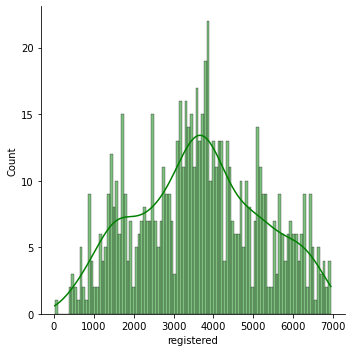

In [3]:
sns.displot(df_bikes_tests['registered'], kde = True, color = "green", bins=100);

Usamos el test de shapiro para comprobar normalidad porque solo tenemos 730 datos.

In [4]:
stats.shapiro(df_bikes_tests["registered"])

ShapiroResult(statistic=0.98438560962677, pvalue=5.023745757171127e-07)

pvalue < 0.05 - luego nuetros datos no son normales

Normalización manual

In [5]:
media = df_bikes_tests["registered"].mean()
maximo = df_bikes_tests["registered"].max() 
minimo = df_bikes_tests["registered"].min()

In [6]:
df_bikes_tests["registered_NORM"] = (df_bikes_tests["registered"] - media) / (maximo - minimo )

In [7]:
df_bikes_tests.head(2)

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,registered,registered_NORM
0,2018-01-01,winter,0,1,1,Monday,0,2,14.110847,80.5833,10.749882,654,-0.433837
1,2018-01-02,winter,0,1,0,Tuesday,1,2,14.902598,69.6087,16.652113,670,-0.431527


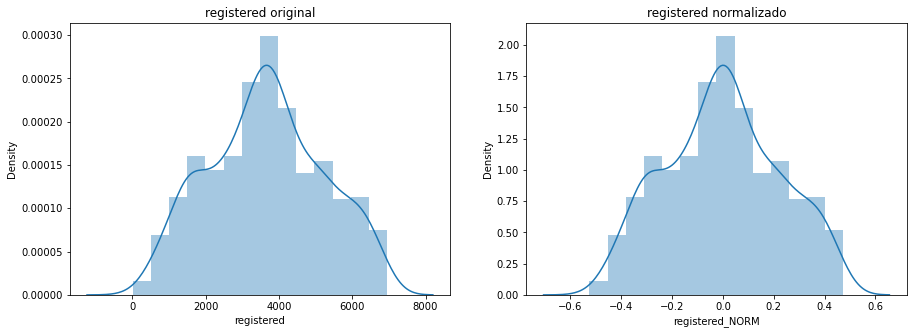

In [8]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('registered original')
axes[1].set_title('registered normalizado')

sns.distplot(df_bikes_tests['registered'] ,ax = axes[0])
sns.distplot(df_bikes_tests["registered_NORM"], ax = axes[1]);

In [9]:
stats.shapiro(df_bikes_tests["registered_NORM"])

ShapiroResult(statistic=0.9843857288360596, pvalue=5.024378424423048e-07)

La normalización manual no nos sirve. Probamos la logarítmica.

In [10]:
df_bikes_tests["registered_LOG"] = df_bikes_tests["registered"].apply(lambda x: np.log(x) if x > 0 else 0)

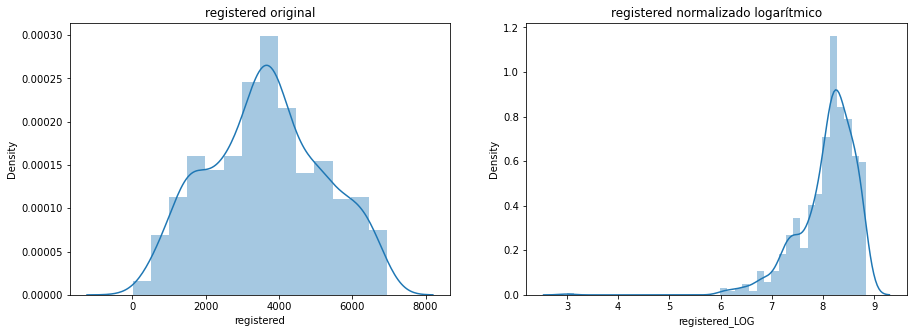

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('registered original')
axes[1].set_title('registered normalizado logarítmico')

sns.distplot(df_bikes_tests["registered"] ,ax = axes[0])
sns.distplot(df_bikes_tests["registered_LOG"], ax = axes[1]);

In [12]:
stats.shapiro(df_bikes_tests["registered_LOG"])

ShapiroResult(statistic=0.8750768303871155, pvalue=9.986205976410893e-24)

La normalización logarítmica no funciona; probamos la raíz cuadrada.

In [13]:
df_bikes_tests["registered_RAIZ"] = df_bikes_tests["registered"].apply(lambda x: math.sqrt(x))

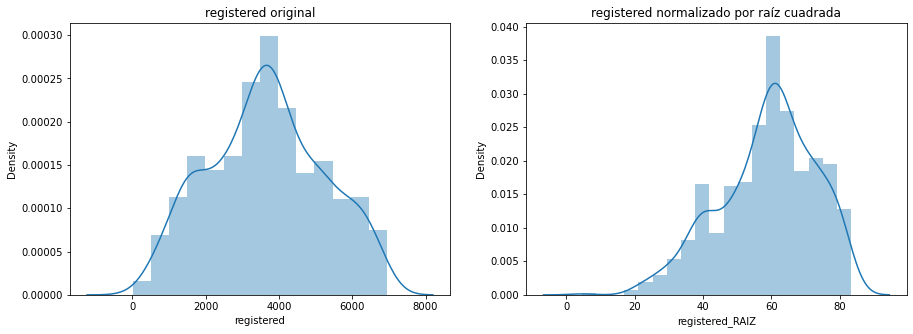

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('registered original')
axes[1].set_title('registered normalizado por raíz cuadrada')

sns.distplot(df_bikes_tests["registered"] ,ax = axes[0])
sns.distplot(df_bikes_tests["registered_RAIZ"], ax = axes[1]);

In [18]:
stats.shapiro(df_bikes_tests["registered_RAIZ"])

ShapiroResult(statistic=0.9734106659889221, pvalue=2.97543378824372e-10)

No funciona la normalización por raíz cuadrada. Probamos por boxcox.

In [19]:
df_bikes_tests['registered_BOX'], lambda_ajustada = stats.boxcox(df_bikes_tests['registered'])

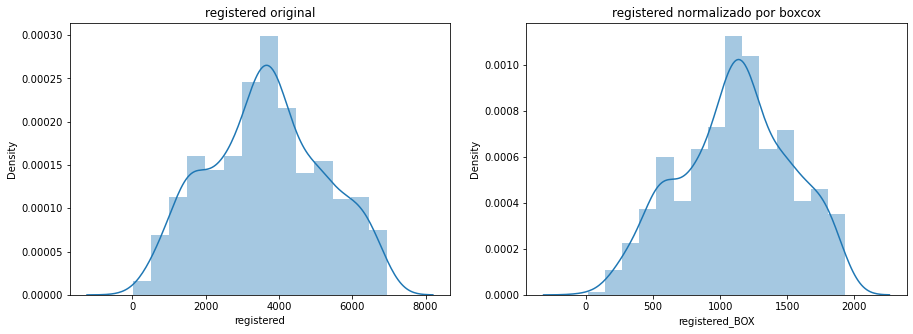

In [21]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))

axes[0].set_title('registered original')
axes[1].set_title('registered normalizado por boxcox')

sns.distplot(df_bikes_tests['registered'] ,ax = axes[0])
sns.distplot(df_bikes_tests['registered_BOX'], ax = axes[1]);

In [22]:
stats.shapiro(df_bikes_tests["registered_BOX"])

ShapiroResult(statistic=0.9854223132133484, pvalue=1.163151068794832e-06)

No podemos normalizar nuestra variable. Por ello, 

### un modelo de regresión lineal no será apropiado en este caso.

Debido a que nuestra variable respuesta no cumple con la asunción de normalidad necesaria para el modelo de regresión lineal, no continuamos con las asunciones y pasamos a un modelo de decision tree o random forest.

In [ ]:
df_bikes_tests.drop(columns = ['registered'], inplace=True)

In [ ]:
df_numericas = df_bikes_tests.filter(['temp', 'hum', 'windspeed'])
df_numericas

,temp,hum,windspeed
0,14.110847,80.5833,10.749882
1,14.902598,69.6087,16.652113
2,8.050924,43.7273,16.636703
3,8.200000,59.0435,10.739832
4,9.305237,43.6957,12.522300
...,...,...,...
725,10.420847,65.2917,23.458911
726,10.386653,59.0000,10.416557
727,10.386653,75.2917,8.333661
728,10.489153,48.3333,23.500518


In [ ]:
# covarianza
df_numericas.cov()

,temp,hum,windspeed
temp,56.350979,13.740700,-6.169865
hum,13.740700,202.708942,-18.383531
windspeed,-6.169865,-18.383531,26.996761


In [ ]:
# correlacion
df_correl = df_numericas.corr(method='spearman')
df_correl

,temp,hum,windspeed
temp,1.000000,0.131518,-0.147233
hum,0.131518,1.000000,-0.239451
windspeed,-0.147233,-0.239451,1.000000
